In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from great_tables import GT, md, html
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

from lstm_ae import LSTMAE, Encoder


df = pd.read_csv('data/MIMICtable.csv')
df

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS
0,1,3,7245486000,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6527.000,50.0,13617.0,520.0,-7090.000,5,2
1,2,3,7245500400,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6577.000,50.0,13982.0,365.0,-7405.000,5,2
2,3,3,7245514800,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6627.000,50.0,14262.0,280.0,-7635.000,5,2
3,4,3,7245529200,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6677.000,50.0,14602.0,340.0,-7925.000,5,1
4,5,3,7245543600,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6727.000,50.0,15142.0,540.0,-8415.000,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266665,8,99995,4612892400,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,6310.0,400.0,-3676.417,0,2
266666,9,99995,4612906800,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7010.0,700.0,-4376.417,0,2
266667,10,99995,4612921200,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7430.0,420.0,-4796.417,0,1
266668,11,99995,4612935600,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7430.0,0.0,-4796.417,4,1


In [3]:
# sofa statistics

sofas = {}
for idx, sofa in zip(df.icustayid, df.SOFA):
    sofas.setdefault(idx, [])
    sofas[idx].append(sofa)

In [4]:
# sepsis label

def has_sepsis(idx):
    return int(any(sofa >= 2 for sofa in sofas[idx]))

df['Sepsis'] = df['icustayid'].apply(has_sepsis)
print(df['Sepsis'].value_counts())

# filter, just patients with sepsis
sepsis_df = df[df['Sepsis'] == 1].drop(columns='Sepsis')

Sepsis
1    264715
0      1955
Name: count, dtype: int64


In [6]:
# sofa deltas

sofa_deltas = {idx: (sofa[-1] - sofa[0]) for idx, sofa in sofas.items()}
sepsis_df.loc[:,'SOFA_delta'] = df.apply(lambda row: sofa_deltas[row.icustayid], axis=1)

sepsis_df

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,SOFA_delta
0,1,3,7245486000,0,17639.0,0,0,0,0,1,...,0.0,0.0,6527.000,50.0,13617.0,520.0,-7090.000,5,2,0
1,2,3,7245500400,0,17639.0,0,0,0,0,1,...,0.0,0.0,6577.000,50.0,13982.0,365.0,-7405.000,5,2,0
2,3,3,7245514800,0,17639.0,0,0,0,0,1,...,0.0,0.0,6627.000,50.0,14262.0,280.0,-7635.000,5,2,0
3,4,3,7245529200,0,17639.0,0,0,0,0,1,...,0.0,0.0,6677.000,50.0,14602.0,340.0,-7925.000,5,1,0
4,5,3,7245543600,0,17639.0,0,0,0,0,1,...,0.0,0.0,6727.000,50.0,15142.0,540.0,-8415.000,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266665,8,99995,4612892400,0,8538.0,0,0,0,0,0,...,0.0,0.0,2633.583,0.0,6310.0,400.0,-3676.417,0,2,-7
266666,9,99995,4612906800,0,8538.0,0,0,0,0,0,...,0.0,0.0,2633.583,0.0,7010.0,700.0,-4376.417,0,2,-7
266667,10,99995,4612921200,0,8538.0,0,0,0,0,0,...,0.0,0.0,2633.583,0.0,7430.0,420.0,-4796.417,0,1,-7
266668,11,99995,4612935600,0,8538.0,0,0,0,0,0,...,0.0,0.0,2633.583,0.0,7430.0,0.0,-4796.417,4,1,-7


In [7]:
print(sepsis_df.columns)

print(f'mimic data shape: {sepsis_df.shape}')

num_icu_stays = len(np.unique(sepsis_df.icustayid))
print(f'total # of icu stays: {num_icu_stays}')

stays = {} # {3: [1235, 1237, 1238], ...}
for idx, time in zip(sepsis_df.icustayid, sepsis_df.charttime):
    stays.setdefault(idx, [])
    stays[idx].append(time)

lens_of_stays = {idx: times[-1] - times[0] for idx, times in stays.items()}

# add column to df
sepsis_df['time_in_icu'] = sepsis_df.apply(lambda row: lens_of_stays[row.icustayid], axis=1)

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'SOFA_delta'],
      dtype='object')
mimic data shape: (264715, 60)
total # of icu stays: 20271


avg # of time points per icu stay: 13.058803216417543


Text(0.5, 0, '# of time points per icu stay')

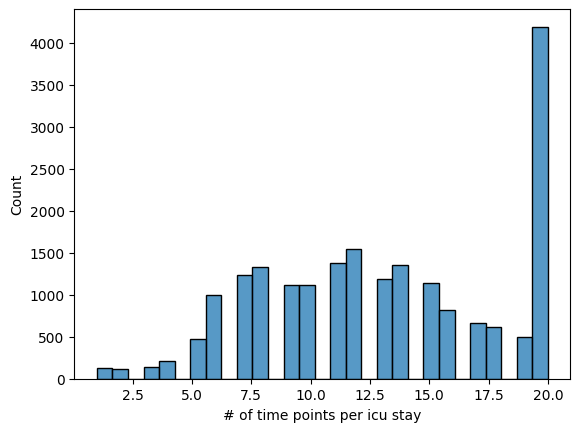

In [6]:
num_time_points_per_stay = [len(times) for times in stays.values()]
print(f'avg # of time points per icu stay: {np.mean(num_time_points_per_stay)}')
sns.histplot(num_time_points_per_stay)
plt.xlabel('# of time points per icu stay')

avg duration of an icu stay (s): 177640.49134231167


Text(0.5, 0, 'duration per icu stay (s)')

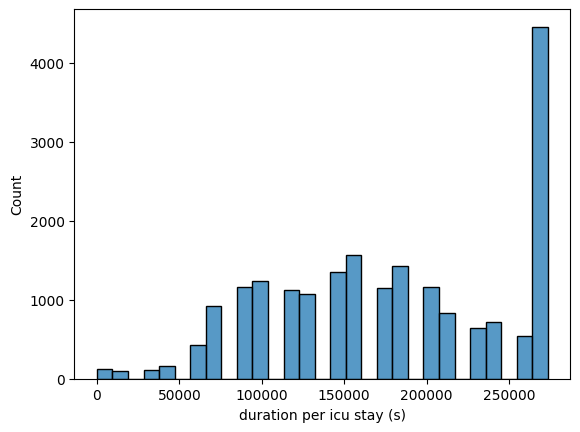

In [6]:
duration_per_stay = [(times[-1] - times[0]) for times in stays.values()]
print(f'avg duration of an icu stay (s): {np.mean(duration_per_stay)}')
sns.histplot(duration_per_stay)
plt.xlabel('duration per icu stay (s)')

In [8]:
# remove any 1-timepoint stays (don't contain any info about state progression)

num_timepoints = sepsis_df['icustayid'].value_counts() # count num of times each id appears
one_timepoint_ids = num_timepoints.index[num_timepoints == 1] # get ids that appear exactly 1x

# filter out these ids
sepsis_df = sepsis_df[ ~sepsis_df['icustayid'].isin(one_timepoint_ids) ]

print(sepsis_df['icustayid'].value_counts())

icustayid
27347    20
61799    20
81157    20
22933    20
22930    20
         ..
44063     2
29723     2
81619     2
58588     2
56124     2
Name: count, Length: 20148, dtype: int64


In [9]:
# time resolution (delta between time points)

time_deltas = []

last_idx = sepsis_df.icustayid[0]
last_time = sepsis_df.charttime[0]
for idx, time in zip(sepsis_df.icustayid, sepsis_df.charttime):
    if idx == last_idx:
        time_deltas.append(time - last_time)
    last_idx, last_time = idx, time


pd.Series(time_deltas).value_counts()

# note: this is an artifact of preprocessing into 4-hour bins!

14400     240817
28800       2312
43200        855
57600        307
72000        112
86400         31
100800         4
115200         2
0              1
158400         1
129600         1
144000         1
172800         1
Name: count, dtype: int64

In [10]:
# initial and terminal states

arr1 = sepsis_df['icustayid'][:-1].to_numpy()
arr2 = sepsis_df['icustayid'][1:].to_numpy()
transitions = np.not_equal(arr1, arr2) # if adjacent icustayids do not match --> transition between trajectories

initial_states = np.append([True], transitions) # the very first state is also an initial state
sepsis_df['initial_state'] = initial_states.astype(int)

terminal_states = np.append(transitions, [True]) # the very last state is also a terminal state
sepsis_df['terminal_state'] = terminal_states.astype(int)

sepsis_df

/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_25357/54777411.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df['initial_state'] = initial_states.astype(int)
/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_25357/54777411.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df['terminal_state'] = terminal_states.astype(int)


,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,SOFA_delta,time_in_icu,initial_state,terminal_state
0,1,3,7245486000,0,17639.0,0,0,0,0,1,...,50.0,13617.0,520.0,-7090.000,5,2,0,72000,1,0
1,2,3,7245500400,0,17639.0,0,0,0,0,1,...,50.0,13982.0,365.0,-7405.000,5,2,0,72000,0,0
2,3,3,7245514800,0,17639.0,0,0,0,0,1,...,50.0,14262.0,280.0,-7635.000,5,2,0,72000,0,0
3,4,3,7245529200,0,17639.0,0,0,0,0,1,...,50.0,14602.0,340.0,-7925.000,5,1,0,72000,0,0
4,5,3,7245543600,0,17639.0,0,0,0,0,1,...,50.0,15142.0,540.0,-8415.000,5,2,0,72000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266665,8,99995,4612892400,0,8538.0,0,0,0,0,0,...,0.0,6310.0,400.0,-3676.417,0,2,-7,158400,0,0
266666,9,99995,4612906800,0,8538.0,0,0,0,0,0,...,0.0,7010.0,700.0,-4376.417,0,2,-7,158400,0,0
266667,10,99995,4612921200,0,8538.0,0,0,0,0,0,...,0.0,7430.0,420.0,-4796.417,0,1,-7,158400,0,0
266668,11,99995,4612935600,0,8538.0,0,0,0,0,0,...,0.0,7430.0,0.0,-4796.417,4,1,-7,158400,0,0


In [53]:
# mortality statistics

num_patients = len(np.unique(sepsis_df['icustayid']))

num_died_in_hosp = len(np.unique(sepsis_df['icustayid'][sepsis_df['died_in_hosp'] == 1]))
mort_rate_hosp = num_died_in_hosp / num_patients
print(f'mortality rate in hospital: {mort_rate_hosp}')

num_died_within_48h = len(np.unique(sepsis_df['icustayid'][sepsis_df['died_within_48h_of_out_time'] == 1]))
mort_rate_48h = num_died_within_48h / num_patients # why is this lower than hospital rate?
print(f'mortality rate 0 - 48 hours after leaving icu: {mort_rate_48h}')

num_died_within_90d = len(np.unique(sepsis_df['icustayid'][sepsis_df['mortality_90d'] == 1]))
mort_rate_90d = num_died_within_90d / num_patients
print(f'mortality rate 0 - 90 days after leaving icu: {mort_rate_90d}')

mortality rate in hospital: 0.14254516577327775
mortality rate 0 - 48 hours after leaving icu: 0.10651181258685725
mortality rate 0 - 90 days after leaving icu: 0.23853484216795712


In [11]:
num_died_out_hosp_within_48h = len(
    np.unique(
        sepsis_df.loc[
            (sepsis_df['died_in_hosp'] == 0) & (sepsis_df['died_within_48h_of_out_time'] == 1),
            'icustayid'
        ]
    )
)
num_died_in_hosp_within_48h = len(
    np.unique(
        sepsis_df.loc[
            (sepsis_df['died_in_hosp'] == 1) & (sepsis_df['died_within_48h_of_out_time'] == 1),
            'icustayid'
        ]
    )
)

num_died_in_hosp_after_48h = len(
    np.unique(
        sepsis_df.loc[
            (sepsis_df['died_in_hosp'] == 1) & (sepsis_df['died_within_48h_of_out_time'] == 0),
            'icustayid'
        ]
    )
)

print(f'# of deaths out of the hospital, <= 48h after icu discharge: {num_died_out_hosp_within_48h}')
print(f'# of deaths in the hospital, <= 48h after icu discharge: {num_died_in_hosp_within_48h}')
print(f'# of deaths in the hospital, > 48h after icu discharge: {num_died_in_hosp_after_48h}')

print(f'mortality rate for in hospital or within 48h of icu discharge: {(num_died_out_hosp_within_48h + num_died_in_hosp_within_48h + num_died_in_hosp_after_48h) / num_patients}')


sepsis_df['died_in_hosp_or_within_48h'] = sepsis_df['died_in_hosp'] | sepsis_df['died_within_48h_of_out_time']
sepsis_df


# I'm leaning towards choosing this new metric b/c the important component is temporal (48h) not location (hospital). however, I also want to include people who die during their icu stay.
# however, it's also very very similar to the in-hospital mortality rate, so I might just use that instead
# however however, papers seem very mixed. komorowski, et al use 90-day (super confounding). more recent papers are pretty split between 48h and in-hospital

# final decision: in hosp!

# of deaths out of the hospital, <= 48h after icu discharge: 17
# of deaths in the hospital, <= 48h after icu discharge: 2129
# of deaths in the hospital, > 48h after icu discharge: 743
mortality rate for in hospital or within 48h of icu discharge: 0.14338892197736747


/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_7593/2852811244.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df['died_in_hosp_or_within_48h'] = sepsis_df['died_in_hosp'] | sepsis_df['died_within_48h_of_out_time']


,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,SOFA_delta,time_in_icu,terminal_state,died_in_hosp_or_within_48h
0,1,3,7245486000,0,17639.0,0,0,0,0,1,...,50.0,13617.0,520.0,-7090.000,5,2,0,72000,0,0
1,2,3,7245500400,0,17639.0,0,0,0,0,1,...,50.0,13982.0,365.0,-7405.000,5,2,0,72000,0,0
2,3,3,7245514800,0,17639.0,0,0,0,0,1,...,50.0,14262.0,280.0,-7635.000,5,2,0,72000,0,0
3,4,3,7245529200,0,17639.0,0,0,0,0,1,...,50.0,14602.0,340.0,-7925.000,5,1,0,72000,0,0
4,5,3,7245543600,0,17639.0,0,0,0,0,1,...,50.0,15142.0,540.0,-8415.000,5,2,0,72000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266665,8,99995,4612892400,0,8538.0,0,0,0,0,0,...,0.0,6310.0,400.0,-3676.417,0,2,-7,158400,0,0
266666,9,99995,4612906800,0,8538.0,0,0,0,0,0,...,0.0,7010.0,700.0,-4376.417,0,2,-7,158400,0,0
266667,10,99995,4612921200,0,8538.0,0,0,0,0,0,...,0.0,7430.0,420.0,-4796.417,0,1,-7,158400,0,0
266668,11,99995,4612935600,0,8538.0,0,0,0,0,0,...,0.0,7430.0,0.0,-4796.417,4,1,-7,158400,0,0


In [34]:
# rewards

def get_reward(row):
    if row['terminal_state'] == 1:
        if row['died_in_hosp'] == 1:
            return -15
        else:
            return 15
    else:
        return 0

sepsis_df.loc[:,'reward'] = sepsis_df.apply(get_reward, axis=1)

print(f'avg reward: {sepsis_df.reward.mean()}')
print(f'avg terminal reward: {sepsis_df.reward[sepsis_df.terminal_state == 1].mean()}')

avg reward: 0.8165779766584024
avg terminal reward: 10.723645026801668


/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_7593/581946155.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df.loc[:,'reward'] = sepsis_df.apply(get_reward, axis=1)


avg SOFA of alive patient: 5.402479647203204
avg SOFA of dead patient: 8.846467810445883


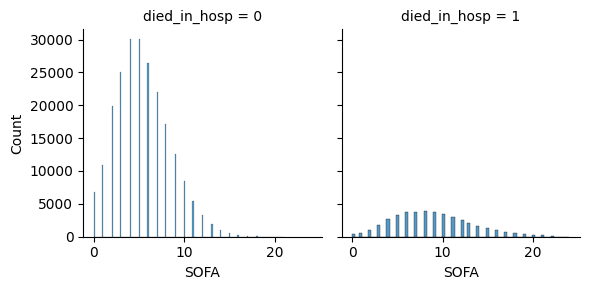

In [35]:
# sofas

avg_sofa_alive = np.mean(sepsis_df['SOFA'][df['died_in_hosp'] == 0])
print(f'avg SOFA of alive patient: {avg_sofa_alive}')

avg_sofa_dead = np.mean(sepsis_df['SOFA'][df['died_in_hosp'] == 1])
print(f'avg SOFA of dead patient: {avg_sofa_dead}')

g = sns.FacetGrid(sepsis_df, col='died_in_hosp')
g.map(sns.histplot, 'SOFA')

avg SOFA delta of alive patient: -1.333673483149098
avg SOFA delta of dead patient: 0.6631309176336584


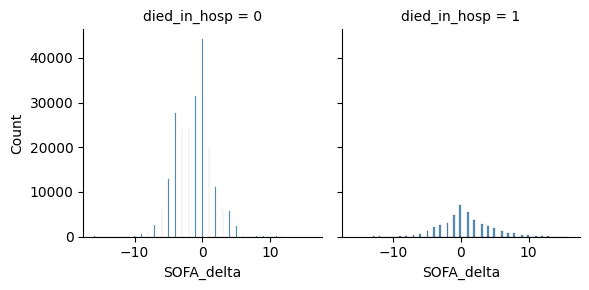

In [14]:
# sofa deltas

avg_sofa_delta_alive = np.mean(sepsis_df['SOFA_delta'][sepsis_df['died_in_hosp'] == 0])
print(f'avg SOFA delta of alive patient: {avg_sofa_delta_alive}')

avg_sofa_delta_dead = np.mean(sepsis_df['SOFA_delta'][sepsis_df['died_in_hosp'] == 1])
print(f'avg SOFA delta of dead patient: {avg_sofa_delta_dead}')

g = sns.FacetGrid(sepsis_df, col='died_in_hosp')
g.map(sns.histplot, 'SOFA_delta')

In [36]:
# demographics and outcomes

# aggregate df
summary = sepsis_df.groupby('died_in_hosp').agg(
    percent_female = ('gender', lambda x: 100 * (x == 1).mean()),
    mean_age = ('age', 'mean'),
    icu_hours = ('time_in_icu', 'mean'),
    total_population = ('gender', 'count')
)

summary['mean_age'] /= 365 # days -> years
summary['icu_hours'] /= 60*60 # seconds -> hours

# Rename rows for readability
summary.index = summary.index.map({0: "Survivors", 1: "Non-survivors"})

# Round and format
summary = summary.round({'percent_female': 1, 'mean_age': 1, 'icu_hours': 1})
summary['total_population'] = summary['total_population'].apply(lambda x: f"{x:,}")

# Reorder columns
summary = summary[['percent_female', 'mean_age', 'icu_hours', 'total_population']]
summary.columns = ['% Female', 'Mean Age', 'Hours in ICU', 'Total Population']

print('Summary stats for sepsis patients in ICU:')

# Display
summary

Summary stats for sepsis patients in ICU:


,% Female,Mean Age,Hours in ICU,Total Population
died_in_hosp,,,,
Survivors,44.0,63.9,55.9,"222,451"
Non-survivors,42.8,68.7,62.9,"42,141"


In [16]:
# pca, could be useful for continuous state-space vector

np.random.seed(42)

# TODO: should I include SOFA?
state_cols = ['gender', 'age', 'elixhauser', 're_admission',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'SOFA', 'SIRS', 'cumulated_balance']
X = sepsis_df[state_cols].values

# normalize values in X to prevent the scale from skewing variable importance
X_scaled = StandardScaler().fit_transform(X)  # mean=0, std=1


pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data={
    'pca_1': pca_result[:, 0],
    'pca_2': pca_result[:, 1],
    'pca_3': pca_result[:, 2],
    'died_in_hosp': sepsis_df['died_in_hosp'].values,
})

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.07919195 0.06443734 0.05308595]


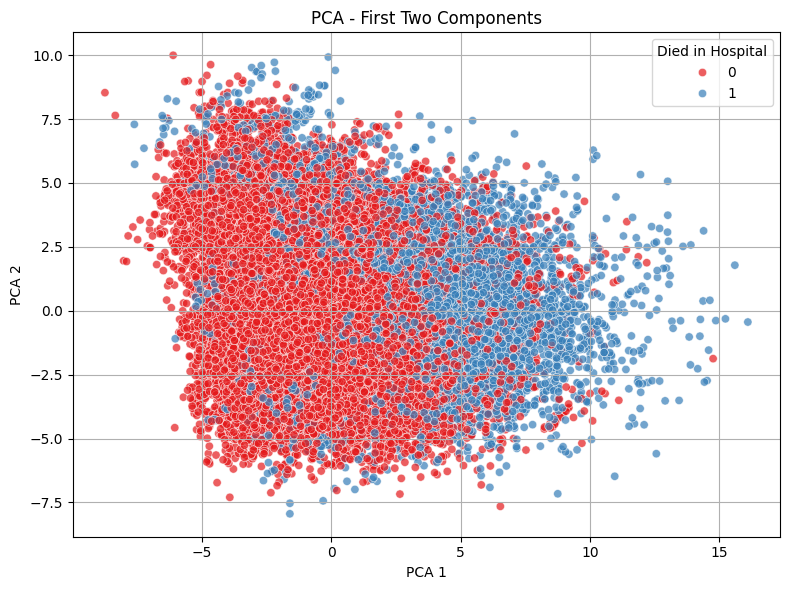

In [17]:
# plot pca in 2d

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='died_in_hosp',
    palette='Set1',
    data=pca_df,
    alpha=0.7
)
plt.title('PCA - First Two Components')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Died in Hospital')
plt.grid(True)
plt.tight_layout()
plt.show()

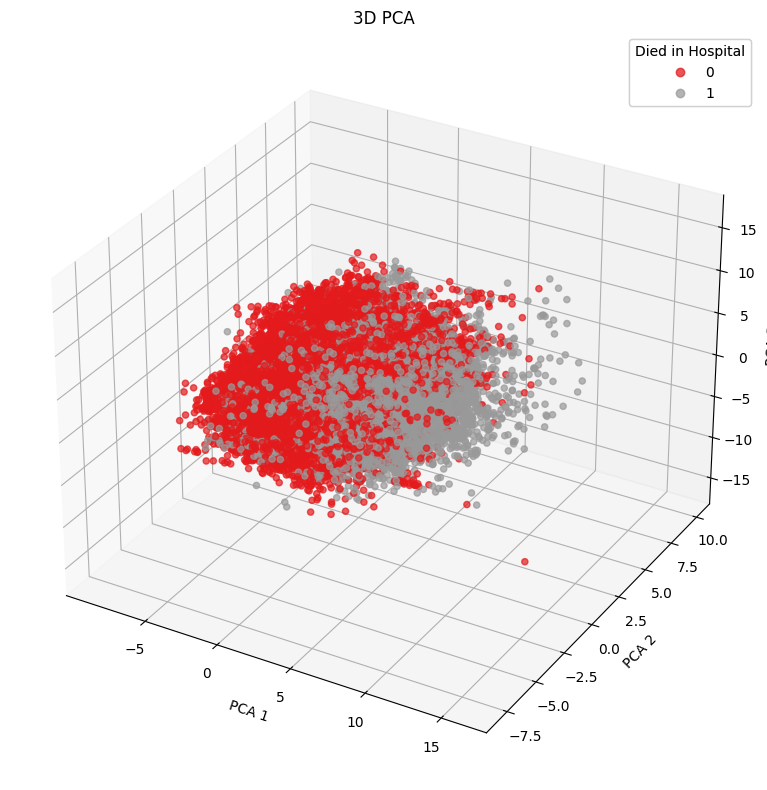

In [18]:
# plot pca in 3d

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df['pca_1'], pca_df['pca_2'], pca_df['pca_3'],
    c=pca_df['died_in_hosp'], cmap='Set1', alpha=0.7
)
ax.set_title('3D PCA')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
legend1 = ax.legend(*scatter.legend_elements(), title='Died in Hospital')
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

In [ ]:
# t-sne

tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
tsne_result = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data={
    'tsne_1': tsne_result[:, 0],
    'tsne_2': tsne_result[:, 1],
    'died_in_hosp': sepsis_df['died_in_hosp'].values
})

In [187]:
# pca then t-sne


# PCA first to reduce dimensionality

pca_10 = PCA(n_components=10)
#pca_result_30 = pca_30.fit_transform(X_scaled)
pca_result_10 = pca_10.fit_transform(X)

print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))


tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
tsne_result = tsne.fit_transform(pca_result_30)

tsne_df = pd.DataFrame(data={
    'tsne_1': tsne_result[:, 0],
    'tsne_2': tsne_result[:, 1],
    'died_in_hosp': sepsis_df['died_in_hosp'].values,
    'Sepsis': sepsis_df['Sepsis'].values
})

Cumulative explained variation for 10 principal components: 0.9999566507498429


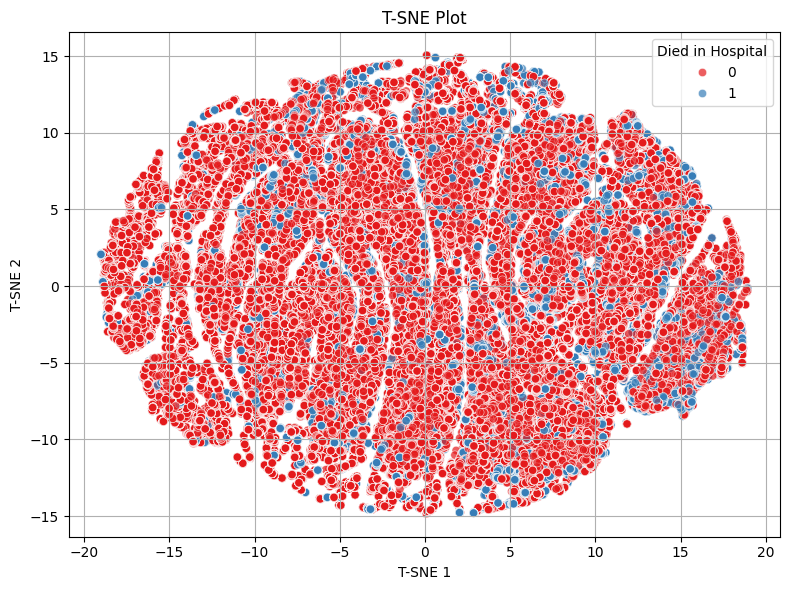

In [190]:
# plot t-sne

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='died_in_hosp',
    palette='Set1',
    data=tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='Died in Hospital')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# create discrete action bins (vasopressors)

# NOTE: using max_dose_vaso. this is the maximum dose from within a 4 hour period
# NOTE: the units for vasopressor dosage are µg/kg/min (I think)

# clip any vasopressor doses that are straight up unrealistic (clinical boundary clipping comes later).
max_max_dose_vaso = 100
sepsis_df = sepsis_df[sepsis_df['max_dose_vaso'] < max_max_dose_vaso]

vasos = sepsis_df['max_dose_vaso']
vasos_nonzero = vasos[vasos != 0]

q1 = np.quantile(vasos_nonzero, 0.25)
q2 = np.quantile(vasos_nonzero, 0.5)
q3 = np.quantile(vasos_nonzero, 0.75)
q4 = np.quantile(vasos_nonzero, 1.0)

bins = (0, q1, q2, q3, q4)
print(bins)

sepsis_df['vaso_bin'] = np.digitize(vasos, bins, right=True)

print(sepsis_df['max_dose_vaso'].value_counts())
print(sepsis_df['vaso_bin'].value_counts())

#list(zip(sepsis_df['max_dose_vaso'], sepsis_df['vaso_bin']))

(0, 0.08, 0.2, 0.45, 93.88)
max_dose_vaso
0.000    226066
0.200      2545
0.225      2461
0.450      1785
0.100      1673
          ...  
1.230         1
1.236         1
1.496         1
1.160         1
1.937         1
Name: count, Length: 1630, dtype: int64
vaso_bin
0    226066
1     10514
2      9949
3      9895
4      8165
Name: count, dtype: int64


/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_25357/1419833960.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df['vaso_bin'] = np.digitize(vasos, bins, right=True)


In [12]:
# create discrete action bins (IV fluids)

ivs = sepsis_df['input_4hourly']
ivs_nonzero = ivs[ivs != 0]

q1 = np.quantile(ivs_nonzero, 0.25)
q2 = np.quantile(ivs_nonzero, 0.5)
q3 = np.quantile(ivs_nonzero, 0.75)
q4 = np.quantile(ivs_nonzero, 1.0)

bins = (0, q1, q2, q3, q4)
print(bins)

sepsis_df['iv_bin'] = np.digitize(ivs, bins, right=True)

print(sepsis_df['input_4hourly'].value_counts())
print(sepsis_df['iv_bin'].value_counts())

(0, 42.5, 130.048, 445.83362499999976, 13199.3943666667)
input_4hourly
0.000000      68097
40.000000     16695
50.000000      9665
20.000000      6090
25.000000      3346
              ...  
468.965083        1
340.980000        1
350.980000        1
216.129930        1
473.583000        1
Name: count, Length: 73781, dtype: int64
iv_bin
0    68097
1    49132
4    49123
3    49123
2    49114
Name: count, dtype: int64


/var/folders/v2/f1t1dtnx68gdxz4b8jh0krd00000gp/T/ipykernel_25357/1842778997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_df['iv_bin'] = np.digitize(ivs, bins, right=True)


In [13]:
print(sepsis_df.columns)

export_cols = ['icustayid', 'gender', 'age', 'elixhauser', 're_admission', 'died_in_hosp', 'Weight_kg',
              'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium',
              'Chloride', 'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 
              'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH',
              'paO2', 'paCO2', 'Arterial_BE', 'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2', 
               'cumulated_balance', 'SOFA', 'SIRS', 'max_dose_vaso', 'vaso_bin', 'input_4hourly', 'iv_bin', 'initial_state', 
               'terminal_state']

export_df = sepsis_df[export_cols]
export_df.to_csv('data/sepsis_df.csv')

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'SOFA_delta', 'time_in_icu', 'initial_state', 'terminal_state',
       'vaso_bin', 'iv_bin'],
      dtype='object')
